In [36]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torchinfo import summary
from tqdm import tqdm

import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
from pandas import read_csv

In [2]:
import random
import os

seed_value = 42

random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device
# torch.use_deterministic_algorithms(True)

'cuda'

# Loading Dataset

In [3]:
train = pd.read_csv('/kaggle/input/har-using-deep-nn/train.csv')
train.sample()

,tBodyAcc_mean_X,tBodyAcc_mean_Y,tBodyAcc_mean_Z,tBodyAcc_std_X,tBodyAcc_std_Y,tBodyAcc_std_Z,tBodyAcc_mad_X,tBodyAcc_mad_Y,tBodyAcc_mad_Z,tBodyAcc_max_X,...,angletBodyAccMeangravity,angletBodyAccJerkMeangravityMean,angletBodyGyroMeangravityMean,angletBodyGyroJerkMeangravityMean,angleXgravityMean,angleYgravityMean,angleZgravityMean,subject,Activity,ActivityName
4525,0.283203,-0.047024,-0.168986,0.384949,0.176898,-0.310332,0.381757,0.122611,-0.332984,0.465563,...,-0.034924,0.558036,0.258975,-0.854858,-0.78433,0.22296,-0.066506,22,3,WALKING_DOWNSTAIRS


In [4]:
train.shape

(7352, 564)

In [5]:
test = pd.read_csv('/kaggle/input/har-using-deep-nn/test.csv')
test.sample()

,tBodyAcc_mean_X,tBodyAcc_mean_Y,tBodyAcc_mean_Z,tBodyAcc_std_X,tBodyAcc_std_Y,tBodyAcc_std_Z,tBodyAcc_mad_X,tBodyAcc_mad_Y,tBodyAcc_mad_Z,tBodyAcc_max_X,...,angletBodyAccMeangravity,angletBodyAccJerkMeangravityMean,angletBodyGyroMeangravityMean,angletBodyGyroJerkMeangravityMean,angleXgravityMean,angleYgravityMean,angleZgravityMean,subject,Activity,ActivityName
718,0.3659,-0.031332,-0.024079,0.183421,-0.344568,-0.403268,0.09989,-0.3422,-0.412337,0.4803,...,-0.37837,-0.840289,-0.864326,0.848585,-0.960939,0.116422,-0.003858,9,3,WALKING_DOWNSTAIRS


In [6]:
test.shape

(2947, 564)

In [7]:
print('Duplicates in train = {}'.format(sum(train.duplicated())))
print('Duplicates in test = {}'.format(sum(test.duplicated())))
print('Invalid values in train = {}'.format(train.isnull().values.sum()))
print('Invalid values in test = {}'.format(test.isnull().values.sum()))

Duplicates in train = 0
Duplicates in test = 0
Invalid values in train = 0
Invalid values in test = 0


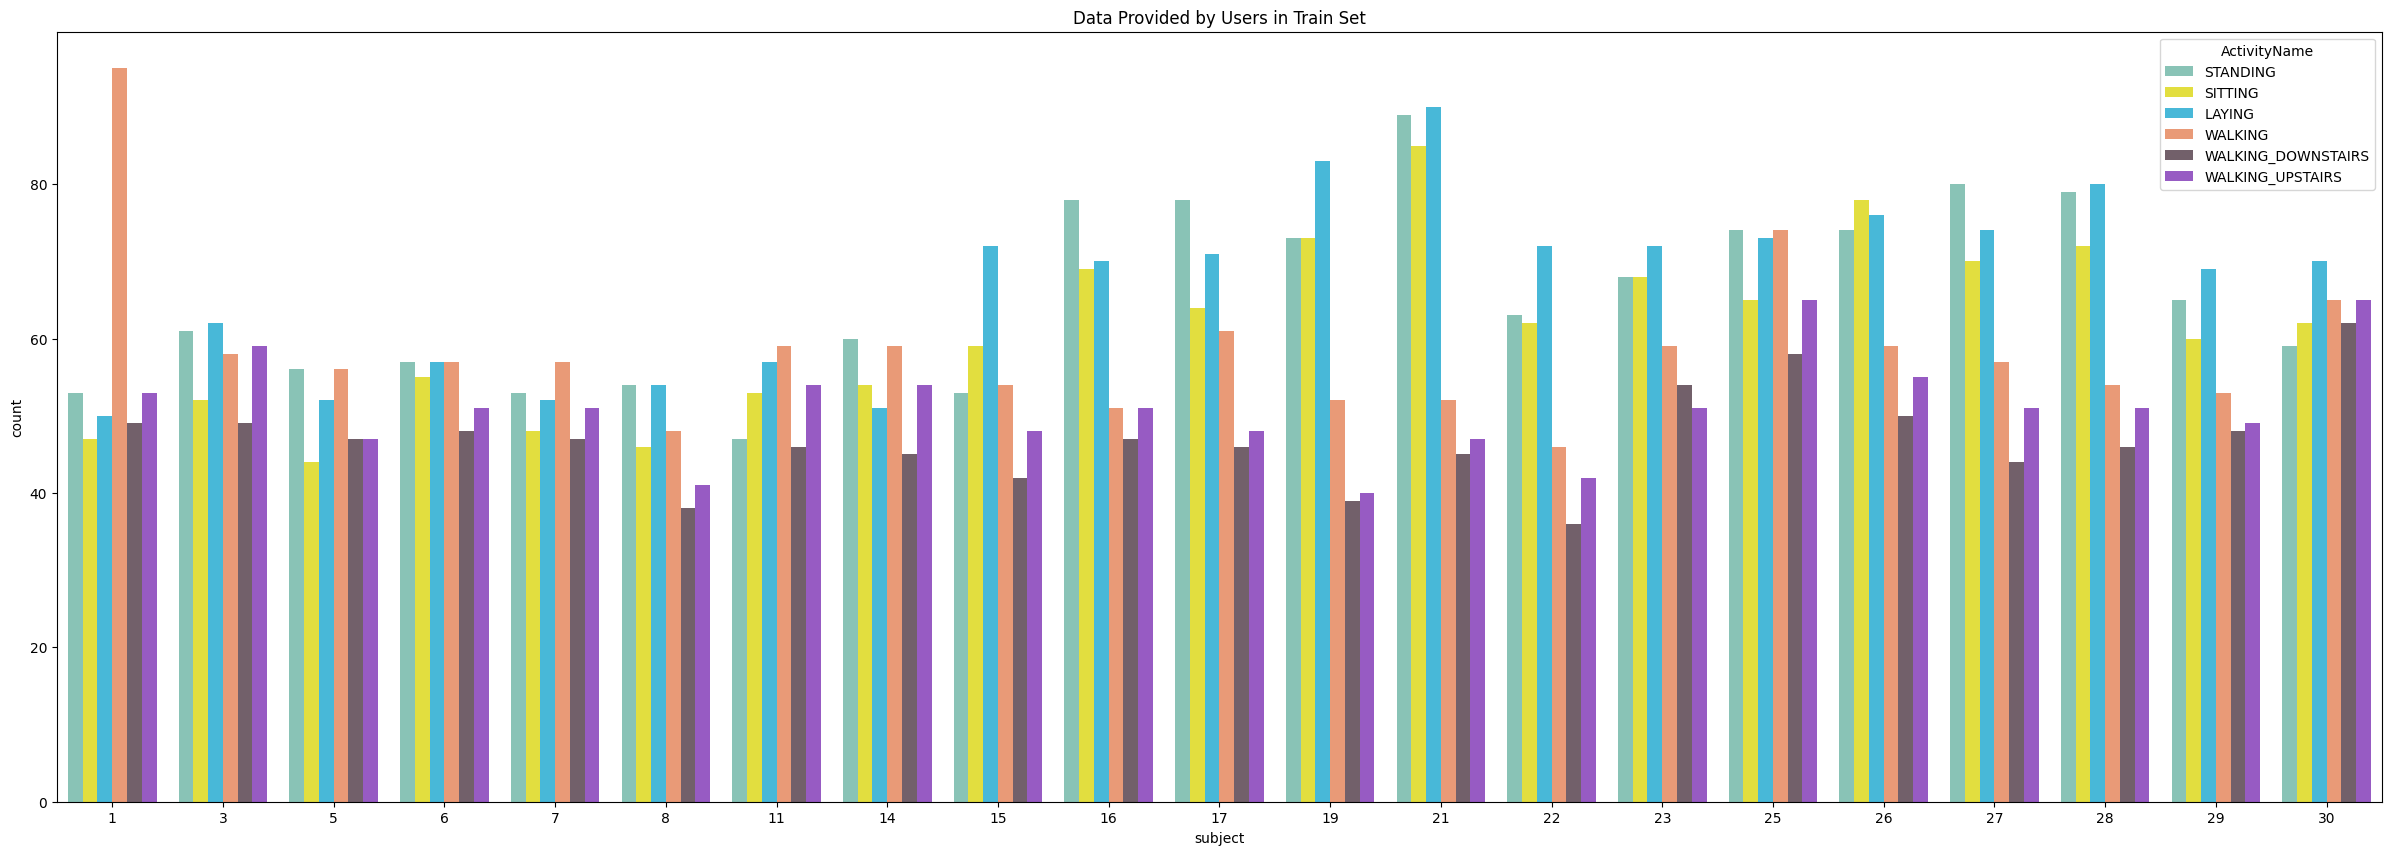

In [8]:
plt.figure(figsize=(30,10))
sns.countplot(x='subject',hue='ActivityName',palette= ["#7fcdbb","#fdf824","#30c6f0","#fc9264","#755d6b","#9a4ad4"], data = train)
plt.title('Data Provided by Users in Train Set')
plt.show()

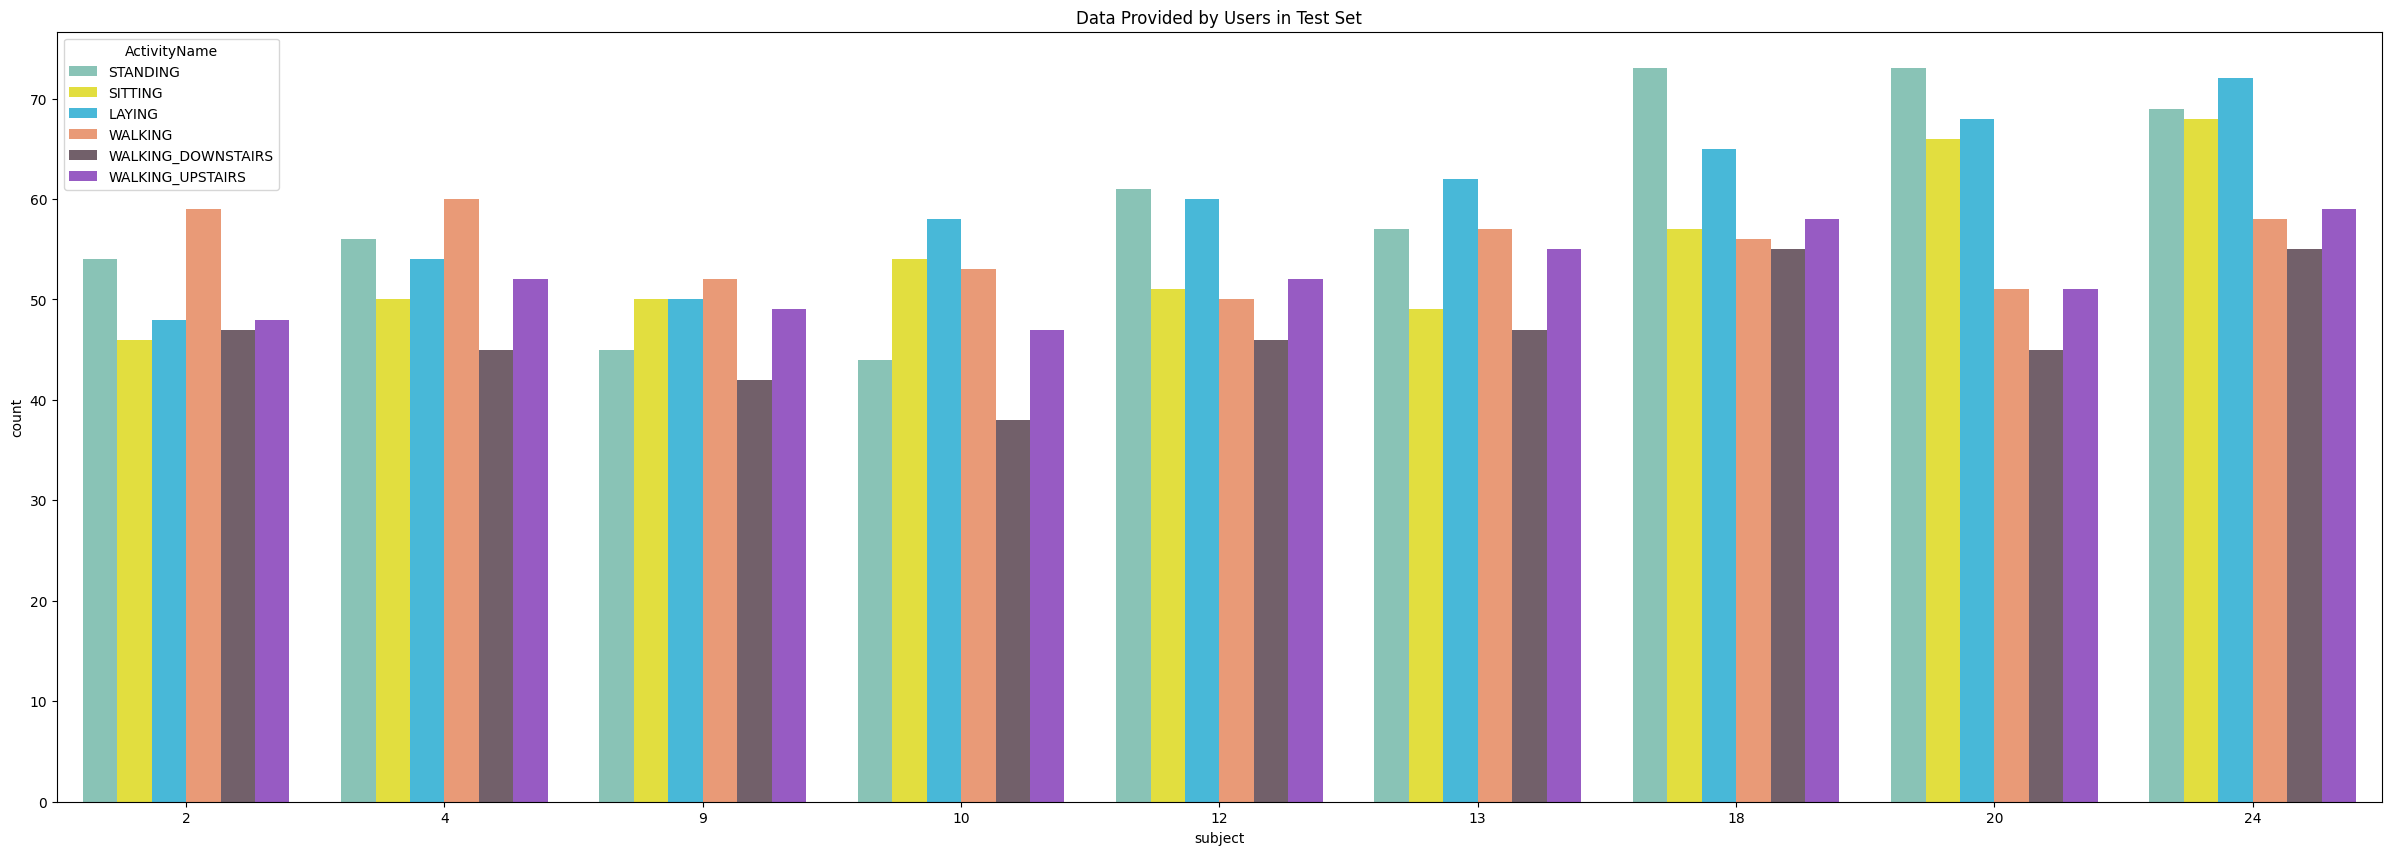

In [9]:
plt.figure(figsize=(30,10))
sns.countplot(x='subject',hue='ActivityName',palette= ["#7fcdbb","#fdf824","#30c6f0","#fc9264","#755d6b","#9a4ad4"], data = test)
plt.title('Data Provided by Users in Test Set')
plt.show()

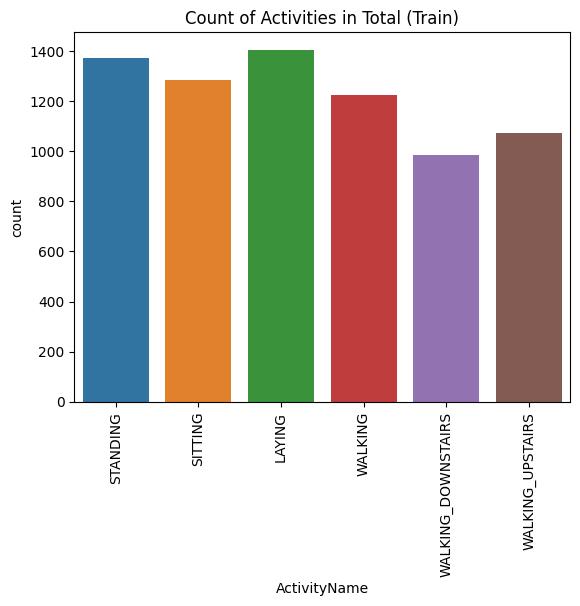

In [10]:
plt.title('Count of Activities in Total (Train)')
sns.countplot(x="ActivityName",data=train)
plt.xticks(rotation=90)
plt.show()

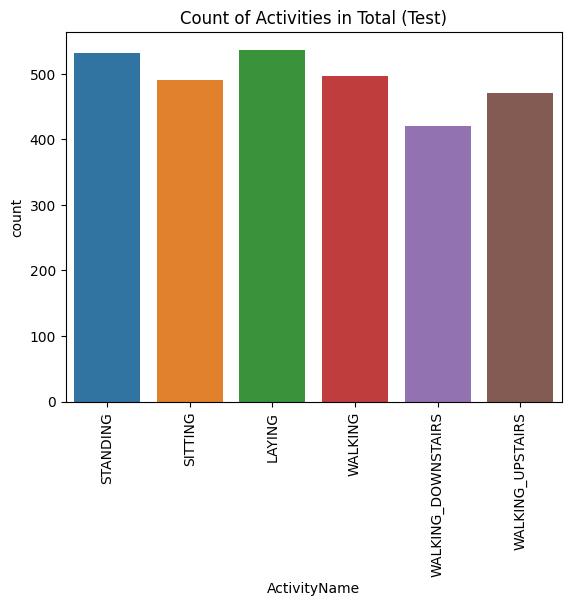

In [11]:
plt.title('Count of Activities in Total (Test)')
sns.countplot(x="ActivityName",data=test)
plt.xticks(rotation=90)
plt.show()

In [12]:
def file_load(filepath):
    df = read_csv(filepath, header=None, sep='\s+')
    return df.values

In [13]:
def train_test_append(filenames, append_before=''):
    datalist = list()
    for name in filenames:
        data = file_load(append_before + name)
        datalist.append(data)
    datalist = np.dstack(datalist)
    return datalist

In [14]:
def inertial_signals_load(group, append_before=''):
    filepath = append_before + group + '/Inertial Signals/'
    filenames = list()
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    X = train_test_append(filenames, filepath)
    y = file_load(append_before + group + '/y_'+group+'.txt')
    return X, y

In [15]:
def load_dataset(append_before=''):
    trainX, trainy = inertial_signals_load('train', append_before + '/kaggle/input/ucihar-dataset/UCI-HAR Dataset/')
    testX, testy = inertial_signals_load('test', append_before + '/kaggle/input/ucihar-dataset/UCI-HAR Dataset/')
    trainy = trainy - 1
    testy = testy - 1
    trainy = pd.get_dummies(trainy[:,0], dtype=int).values
    testy = pd.get_dummies(testy[:,0], dtype=int).values
    print(trainX.shape, trainy.shape, testX.shape, testy.shape)
    return trainX, trainy, testX, testy

In [16]:
trainX, trainy, testX, testy = load_dataset()
verbose, epochs, batch_size = 0, 100, 200
n_timesteps = trainX.shape[1]
n_features = trainX.shape[2]
n_outputs = trainy.shape[1]
# n_steps = 4
# n_length = 32
# trainX = trainX.reshape((trainX.shape[0], n_steps, n_length, n_features))
# testX = testX.reshape((testX.shape[0], n_steps, n_length, n_features)) 
print(trainX.shape,testX.shape)

(7352, 128, 9) (7352, 6) (2947, 128, 9) (2947, 6)
(7352, 128, 9) (2947, 128, 9)


## Setting Up the train and test loaders

In [17]:
class HARDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [18]:
train_dataset = HARDataset(trainX, trainy)
test_dataset = HARDataset(testX, testy)

BATCH = 256
train_loader = DataLoader(train_dataset, batch_size=BATCH, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH, shuffle=False)

# Modelling

## Loss Function

In [29]:
def kl_divergence_loss(preds, targets):
    # Ensure that the predictions and targets are probabilities
    preds = F.softmax(preds, dim=-1)
    targets = F.softmax(targets, dim=-1)
    loss = F.kl_div(preds.log(), targets, reduction='batchmean')
    return loss

def mse_loss(preds, targets):
    # Ensure that the predictions and targets are one-hot encoded
    preds = F.softmax(preds, dim=-1)
    return F.mse_loss(preds, targets)

# Focal Loss
def focal_loss(preds, targets, alpha=0.25, gamma=2.0):
    """
    Focal Loss for multi-class classification.
    
    Arguments:
    preds -- the raw logits from the model (shape: [batch_size, num_classes])
    targets -- the true labels (shape: [batch_size])
    alpha -- balancing factor for class imbalances (default is 0.25)
    gamma -- focusing parameter (default is 2.0)
    
    Returns:
    loss -- the computed focal loss
    """
    # Apply softmax to get probabilities
    preds = F.softmax(preds, dim=-1)
    
    # Convert targets to one-hot encoding
    targets_one_hot = targets
    
    # Cross-entropy loss
    ce_loss = F.cross_entropy(preds, targets, reduction='none')
    
    # Get the predicted probability for the correct class
    pt = torch.exp(-ce_loss)
    
    # Compute focal loss
    focal_loss = alpha * (1 - pt) ** gamma * ce_loss
    
    return focal_loss.mean()

# criterion = nn.CrossEntropyLoss() # -> 96.89% 93.55%
# criterion = kl_divergence_loss # -> 99.09% 94.81%
# criterion = mse_loss # -> 96.27% 92.94%
# criterion = nn.CrossEntropyLoss(label_smoothing=0.1) # -> 97.43% 94.06%
# criterion = focal_loss # -> 97.27% 93.32%

## Optimizer and Learning Rate

In [20]:
def warmup_lr(epoch, step_size, warmup_epochs=5, gamma=0.1):
    if epoch < warmup_epochs:
        return (epoch + 1) / warmup_epochs
    
    else:
        epoch_since_warmup = epoch - warmup_epochs
        return gamma ** (epoch_since_warmup // step_size)

WARMUP_EPOCHS = 14
GAMMA = 0.1
STEP_SIZE = 20

## Plotting Train and Test Acc and Loss

In [21]:
# Plot history
def plot_history(history):
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(12, 4))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss History')

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], label='Train Accuracy')
    plt.plot(epochs, history['val_acc'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy History')

    plt.show()

## Confusion Matrix Function

In [44]:
def plot_confusion_matrix(model, val_loader, class_names, device="cuda"):
    """
    Evaluates the model and plots a confusion matrix with a custom color map.

    Arguments:
    - model: Trained PyTorch model.
    - val_loader: DataLoader for validation dataset.
    - class_names: List of class names for the confusion matrix.
    - device: 'cuda' or 'cpu'.
    """
    model.eval()  # Set model to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad():  # Disable gradient computation
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)  # Predicted classes
            
            # If labels are one-hot encoded, convert them to class indices
            if len(labels.shape) > 1 and labels.size(1) > 1:
                labels = torch.argmax(labels, dim=1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds, labels=np.arange(len(class_names)))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

    # Plot the confusion matrix with customization
    fig, ax = plt.subplots(figsize=(10, 8))  # Set larger figure size
    disp.plot(cmap="YlGnBu", ax=ax, colorbar=True)  # Use "cividis" colormap and add colorbar
    plt.title("Confusion Matrix", fontsize=16)
    plt.xticks(fontsize=12, rotation=45)
    plt.yticks(fontsize=12)
    plt.show()

## Training Function

In [30]:
def train_model(model, train_loader, val_loader, criterion=None, epochs=20, device='cpu', early_stopping=False):
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    patience = 20
    min_delta = 1e-6
    best_loss = np.inf
    patience_counter = 0

    if criterion is None:
        criterion = F.mse_loss
    _criterion = criterion
    
    for epoch in range(epochs):
        model.train()
        train_loss, train_correct = 0.0, 0
        
        # Training phase
        with tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} - Training", unit="batch") as tepoch:
            for inputs, targets in tepoch:
                inputs = inputs.to(device)
                targets = targets.to(device)
                
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = _criterion(outputs, targets)
                loss.backward()
                optimizer.step()
                
                train_loss += loss.item() * inputs.size(0)
                train_correct += (outputs.argmax(1) == targets.argmax(1)).sum().item()

                tepoch.set_postfix(loss=loss.item())

        scheduler.step()

        train_loss /= len(train_loader.dataset)
        train_acc = train_correct / len(train_loader.dataset)

        # Validation phase
        model.eval()
        val_loss, val_correct = 0.0, 0
        with torch.no_grad():
            with tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} - Validation", unit="batch") as vepoch:
                for inputs, targets in vepoch:
                    inputs = inputs.to(device)
                    targets = targets.to(device)
                    
                    outputs = model(inputs)
                    loss = criterion(outputs, targets)
                    val_loss += loss.item() * inputs.size(0)
                    val_correct += (outputs.argmax(1) == targets.argmax(1)).sum().item()

                    vepoch.set_postfix(loss=loss.item())

        val_loss /= len(val_loader.dataset)
        val_acc = val_correct / len(val_loader.dataset)

        # Save history
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

        print(f"Epoch {epoch+1}/{epochs} - "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} - "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        if val_loss < best_loss - min_delta:
            best_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1


        if patience_counter >= patience and early_stopping and epoch > 100:
            print("Early stopping triggered!")
            break

    return history

## Models

### RNN + Attention

In [31]:
class AdaptiveRNN(nn.Module):
    def __init__(self, n_timesteps, n_features, n_outputs):
        super(AdaptiveRNN, self).__init__()

        # Bi-directional LSTM layer
        self.lstm = nn.LSTM(
            input_size=n_features,
            hidden_size=128,
            batch_first=True,
            bidirectional=True
        )
        self.batch_norm = nn.BatchNorm1d(128 * 2)

        # Attention mechanism
        self.attention_dense = nn.Linear(128 * 2, 1)
        
        # Fully connected layers
        self.fc1 = nn.Linear(128 * 2, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, n_outputs)

        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        # LSTM output
        lstm_out, _ = self.lstm(x)  # lstm_out shape: (batch_size, timesteps, 128*2)
        
        batch_size, n_timesteps, n_features = lstm_out.size()
        lstm_out = lstm_out.reshape(batch_size * n_timesteps, n_features)
        lstm_out = self.batch_norm(lstm_out)
        lstm_out = lstm_out.reshape(batch_size, n_timesteps, n_features)
        
        # Attention mechanism
        attention_scores = torch.sigmoid(self.attention_dense(lstm_out))  # (batch_size, timesteps, 1)
        attention_scores = lstm_out * attention_scores  # Weighted timesteps

        # Global average pooling
        pooled = attention_scores.mean(dim=1)
        
        # Fully connected layers
        x = F.relu(self.fc1(pooled))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return F.softmax(x, dim=1)

In [24]:
# Define the model parameters
n_timesteps = 32 * 4  # 128 timesteps
n_features = 9
n_outputs = 6

# Create the model
model = AdaptiveRNN(n_timesteps=n_timesteps, n_features=n_features, n_outputs=n_outputs).to(device)
summary(model)

Layer (type:depth-idx)                   Param #
AdaptiveRNN                              --
├─LSTM: 1-1                              142,336
├─BatchNorm1d: 1-2                       512
├─Linear: 1-3                            257
├─Linear: 1-4                            32,896
├─Linear: 1-5                            8,256
├─Linear: 1-6                            390
├─Dropout: 1-7                           --
Total params: 184,647
Trainable params: 184,647
Non-trainable params: 0

In [25]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)
# scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda x: warmup_lr(x, warmup_epochs=WARMUP_EPOCHS, gamma=GAMMA, step_size=STEP_SIZE))
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = 50, eta_min = 1e-6)

history = train_model(model, train_loader, test_loader, criterion=kl_divergence_loss, epochs=150, device=device, early_stopping=False)

Epoch 1/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 81.22batch/s, loss=0.088]


Epoch 1/150 - Train Loss: 0.0762, Train Acc: 0.5420 - Val Loss: 0.0892, Val Acc: 0.5338


Epoch 2/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 81.70batch/s, loss=0.026]


Epoch 2/150 - Train Loss: 0.0325, Train Acc: 0.8200 - Val Loss: 0.0370, Val Acc: 0.7957


Epoch 3/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 79.30batch/s, loss=0.000706]


Epoch 3/150 - Train Loss: 0.0130, Train Acc: 0.9252 - Val Loss: 0.0202, Val Acc: 0.8836


Epoch 4/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 80.10batch/s, loss=0.000456]


Epoch 4/150 - Train Loss: 0.0100, Train Acc: 0.9407 - Val Loss: 0.0203, Val Acc: 0.8809


Epoch 5/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 83.07batch/s, loss=0.000469]


Epoch 5/150 - Train Loss: 0.0090, Train Acc: 0.9460 - Val Loss: 0.0156, Val Acc: 0.9074


Epoch 6/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 83.28batch/s, loss=0.000158]


Epoch 6/150 - Train Loss: 0.0084, Train Acc: 0.9475 - Val Loss: 0.0146, Val Acc: 0.9131


Epoch 7/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 76.19batch/s, loss=0.000439]


Epoch 7/150 - Train Loss: 0.0082, Train Acc: 0.9509 - Val Loss: 0.0149, Val Acc: 0.9108


Epoch 8/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 79.02batch/s, loss=0.000156]


Epoch 8/150 - Train Loss: 0.0078, Train Acc: 0.9538 - Val Loss: 0.0140, Val Acc: 0.9199


Epoch 9/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 83.48batch/s, loss=0.000614]


Epoch 9/150 - Train Loss: 0.0081, Train Acc: 0.9499 - Val Loss: 0.0141, Val Acc: 0.9070


Epoch 10/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 82.00batch/s, loss=0.000125]


Epoch 10/150 - Train Loss: 0.0078, Train Acc: 0.9536 - Val Loss: 0.0154, Val Acc: 0.8989


Epoch 11/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 83.15batch/s, loss=0.000347]


Epoch 11/150 - Train Loss: 0.0075, Train Acc: 0.9538 - Val Loss: 0.0130, Val Acc: 0.9094


Epoch 12/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 81.46batch/s, loss=0.000181]


Epoch 12/150 - Train Loss: 0.0075, Train Acc: 0.9531 - Val Loss: 0.0129, Val Acc: 0.9169


Epoch 13/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 78.21batch/s, loss=0.000189]


Epoch 13/150 - Train Loss: 0.0074, Train Acc: 0.9554 - Val Loss: 0.0141, Val Acc: 0.9141


Epoch 14/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 80.82batch/s, loss=0.000477]


Epoch 14/150 - Train Loss: 0.0073, Train Acc: 0.9565 - Val Loss: 0.0136, Val Acc: 0.9230


Epoch 15/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 80.66batch/s, loss=0.000939]


Epoch 15/150 - Train Loss: 0.0074, Train Acc: 0.9532 - Val Loss: 0.0143, Val Acc: 0.9158


Epoch 16/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 82.88batch/s, loss=3.71e-5]


Epoch 16/150 - Train Loss: 0.0072, Train Acc: 0.9558 - Val Loss: 0.0129, Val Acc: 0.9175


Epoch 17/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 83.01batch/s, loss=8.8e-5]


Epoch 17/150 - Train Loss: 0.0073, Train Acc: 0.9559 - Val Loss: 0.0123, Val Acc: 0.9209


Epoch 18/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 81.49batch/s, loss=0.000282]


Epoch 18/150 - Train Loss: 0.0075, Train Acc: 0.9533 - Val Loss: 0.0127, Val Acc: 0.9281


Epoch 19/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 82.77batch/s, loss=0.000273]


Epoch 19/150 - Train Loss: 0.0073, Train Acc: 0.9543 - Val Loss: 0.0129, Val Acc: 0.9162


Epoch 20/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 83.15batch/s, loss=3e-5]  


Epoch 20/150 - Train Loss: 0.0071, Train Acc: 0.9577 - Val Loss: 0.0131, Val Acc: 0.9165


Epoch 21/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 83.49batch/s, loss=0.000315]


Epoch 21/150 - Train Loss: 0.0069, Train Acc: 0.9582 - Val Loss: 0.0132, Val Acc: 0.9253


Epoch 22/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 82.59batch/s, loss=0.000287]


Epoch 22/150 - Train Loss: 0.0070, Train Acc: 0.9567 - Val Loss: 0.0135, Val Acc: 0.9213


Epoch 23/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 78.72batch/s, loss=1.89e-5]


Epoch 23/150 - Train Loss: 0.0068, Train Acc: 0.9573 - Val Loss: 0.0137, Val Acc: 0.9125


Epoch 24/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 83.35batch/s, loss=0.000463]


Epoch 24/150 - Train Loss: 0.0070, Train Acc: 0.9567 - Val Loss: 0.0137, Val Acc: 0.9223


Epoch 25/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 81.25batch/s, loss=0.000476]


Epoch 25/150 - Train Loss: 0.0069, Train Acc: 0.9569 - Val Loss: 0.0132, Val Acc: 0.9270


Epoch 26/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 84.08batch/s, loss=4.27e-5]


Epoch 26/150 - Train Loss: 0.0070, Train Acc: 0.9570 - Val Loss: 0.0135, Val Acc: 0.9108


Epoch 27/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 83.37batch/s, loss=0.000131]


Epoch 27/150 - Train Loss: 0.0068, Train Acc: 0.9582 - Val Loss: 0.0131, Val Acc: 0.9138


Epoch 28/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 43.01batch/s, loss=0.000275]


Epoch 28/150 - Train Loss: 0.0068, Train Acc: 0.9587 - Val Loss: 0.0132, Val Acc: 0.9169


Epoch 29/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 81.84batch/s, loss=8.77e-5]


Epoch 29/150 - Train Loss: 0.0067, Train Acc: 0.9593 - Val Loss: 0.0127, Val Acc: 0.9223


Epoch 30/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 83.52batch/s, loss=8.51e-5]


Epoch 30/150 - Train Loss: 0.0066, Train Acc: 0.9595 - Val Loss: 0.0122, Val Acc: 0.9291


Epoch 31/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 80.65batch/s, loss=0.000104]


Epoch 31/150 - Train Loss: 0.0068, Train Acc: 0.9572 - Val Loss: 0.0130, Val Acc: 0.9203


Epoch 32/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 82.06batch/s, loss=0.000436]


Epoch 32/150 - Train Loss: 0.0066, Train Acc: 0.9578 - Val Loss: 0.0136, Val Acc: 0.9141


Epoch 33/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 81.12batch/s, loss=0.000407]


Epoch 33/150 - Train Loss: 0.0067, Train Acc: 0.9582 - Val Loss: 0.0135, Val Acc: 0.9216


Epoch 34/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 83.25batch/s, loss=0.000221]


Epoch 34/150 - Train Loss: 0.0067, Train Acc: 0.9580 - Val Loss: 0.0129, Val Acc: 0.9230


Epoch 35/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 77.66batch/s, loss=7.18e-5]


Epoch 35/150 - Train Loss: 0.0066, Train Acc: 0.9582 - Val Loss: 0.0127, Val Acc: 0.9182


Epoch 36/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 82.70batch/s, loss=0.000445]


Epoch 36/150 - Train Loss: 0.0066, Train Acc: 0.9597 - Val Loss: 0.0126, Val Acc: 0.9274


Epoch 37/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 84.98batch/s, loss=0.000145]


Epoch 37/150 - Train Loss: 0.0064, Train Acc: 0.9585 - Val Loss: 0.0125, Val Acc: 0.9243


Epoch 38/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 80.89batch/s, loss=4.23e-5]


Epoch 38/150 - Train Loss: 0.0064, Train Acc: 0.9604 - Val Loss: 0.0121, Val Acc: 0.9270


Epoch 39/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 76.80batch/s, loss=5.55e-5]


Epoch 39/150 - Train Loss: 0.0064, Train Acc: 0.9595 - Val Loss: 0.0129, Val Acc: 0.9169


Epoch 40/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 80.93batch/s, loss=5.56e-5]


Epoch 40/150 - Train Loss: 0.0064, Train Acc: 0.9596 - Val Loss: 0.0126, Val Acc: 0.9199


Epoch 41/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 83.15batch/s, loss=4.03e-5]


Epoch 41/150 - Train Loss: 0.0064, Train Acc: 0.9597 - Val Loss: 0.0124, Val Acc: 0.9203


Epoch 42/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 82.03batch/s, loss=5.59e-5]


Epoch 42/150 - Train Loss: 0.0062, Train Acc: 0.9597 - Val Loss: 0.0125, Val Acc: 0.9199


Epoch 43/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 82.35batch/s, loss=0.000132]


Epoch 43/150 - Train Loss: 0.0064, Train Acc: 0.9597 - Val Loss: 0.0130, Val Acc: 0.9186


Epoch 44/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 81.91batch/s, loss=4.9e-5] 


Epoch 44/150 - Train Loss: 0.0064, Train Acc: 0.9597 - Val Loss: 0.0126, Val Acc: 0.9206


Epoch 45/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 80.90batch/s, loss=5.71e-5]


Epoch 45/150 - Train Loss: 0.0064, Train Acc: 0.9596 - Val Loss: 0.0126, Val Acc: 0.9216


Epoch 46/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 83.03batch/s, loss=4.05e-5]


Epoch 46/150 - Train Loss: 0.0062, Train Acc: 0.9600 - Val Loss: 0.0127, Val Acc: 0.9203


Epoch 47/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 83.05batch/s, loss=5.49e-5]


Epoch 47/150 - Train Loss: 0.0061, Train Acc: 0.9621 - Val Loss: 0.0127, Val Acc: 0.9199


Epoch 48/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 82.46batch/s, loss=4.52e-5]


Epoch 48/150 - Train Loss: 0.0061, Train Acc: 0.9615 - Val Loss: 0.0127, Val Acc: 0.9199


Epoch 49/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 58.52batch/s, loss=5.05e-5]


Epoch 49/150 - Train Loss: 0.0064, Train Acc: 0.9611 - Val Loss: 0.0127, Val Acc: 0.9206


Epoch 50/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 80.85batch/s, loss=5.29e-5]


Epoch 50/150 - Train Loss: 0.0062, Train Acc: 0.9618 - Val Loss: 0.0127, Val Acc: 0.9206


Epoch 51/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 83.00batch/s, loss=5.76e-5]


Epoch 51/150 - Train Loss: 0.0063, Train Acc: 0.9608 - Val Loss: 0.0128, Val Acc: 0.9203


Epoch 52/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 80.88batch/s, loss=4.47e-5]


Epoch 52/150 - Train Loss: 0.0063, Train Acc: 0.9601 - Val Loss: 0.0127, Val Acc: 0.9203


Epoch 53/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 79.39batch/s, loss=3.88e-5]


Epoch 53/150 - Train Loss: 0.0063, Train Acc: 0.9599 - Val Loss: 0.0126, Val Acc: 0.9192


Epoch 54/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 82.97batch/s, loss=4.09e-5]


Epoch 54/150 - Train Loss: 0.0062, Train Acc: 0.9604 - Val Loss: 0.0126, Val Acc: 0.9206


Epoch 55/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 80.84batch/s, loss=4.6e-5] 


Epoch 55/150 - Train Loss: 0.0062, Train Acc: 0.9606 - Val Loss: 0.0128, Val Acc: 0.9192


Epoch 56/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 80.48batch/s, loss=3.95e-5]


Epoch 56/150 - Train Loss: 0.0064, Train Acc: 0.9589 - Val Loss: 0.0127, Val Acc: 0.9196


Epoch 57/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 83.16batch/s, loss=4.45e-5]


Epoch 57/150 - Train Loss: 0.0063, Train Acc: 0.9612 - Val Loss: 0.0127, Val Acc: 0.9216


Epoch 58/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 81.17batch/s, loss=6.01e-5]


Epoch 58/150 - Train Loss: 0.0063, Train Acc: 0.9610 - Val Loss: 0.0128, Val Acc: 0.9209


Epoch 59/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 82.21batch/s, loss=9.06e-6]


Epoch 59/150 - Train Loss: 0.0064, Train Acc: 0.9596 - Val Loss: 0.0126, Val Acc: 0.9179


Epoch 60/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 83.60batch/s, loss=9.48e-5]


Epoch 60/150 - Train Loss: 0.0063, Train Acc: 0.9593 - Val Loss: 0.0127, Val Acc: 0.9186


Epoch 61/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 82.80batch/s, loss=2.8e-5]


Epoch 61/150 - Train Loss: 0.0061, Train Acc: 0.9601 - Val Loss: 0.0133, Val Acc: 0.9114


Epoch 62/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 80.12batch/s, loss=4.35e-5]


Epoch 62/150 - Train Loss: 0.0062, Train Acc: 0.9592 - Val Loss: 0.0141, Val Acc: 0.9145


Epoch 63/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 80.00batch/s, loss=0.000338]


Epoch 63/150 - Train Loss: 0.0063, Train Acc: 0.9592 - Val Loss: 0.0136, Val Acc: 0.9138


Epoch 64/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 82.55batch/s, loss=0.000173]


Epoch 64/150 - Train Loss: 0.0063, Train Acc: 0.9607 - Val Loss: 0.0132, Val Acc: 0.9158


Epoch 65/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 82.84batch/s, loss=8.61e-7]


Epoch 65/150 - Train Loss: 0.0063, Train Acc: 0.9597 - Val Loss: 0.0130, Val Acc: 0.9165


Epoch 66/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 82.44batch/s, loss=0.000131]


Epoch 66/150 - Train Loss: 0.0064, Train Acc: 0.9592 - Val Loss: 0.0137, Val Acc: 0.9145


Epoch 67/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 79.81batch/s, loss=7.81e-5]


Epoch 67/150 - Train Loss: 0.0064, Train Acc: 0.9585 - Val Loss: 0.0127, Val Acc: 0.9175


Epoch 68/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 82.51batch/s, loss=5.91e-5]


Epoch 68/150 - Train Loss: 0.0063, Train Acc: 0.9595 - Val Loss: 0.0132, Val Acc: 0.9158


Epoch 69/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 82.87batch/s, loss=2.3e-5] 


Epoch 69/150 - Train Loss: 0.0063, Train Acc: 0.9607 - Val Loss: 0.0151, Val Acc: 0.9118


Epoch 70/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 79.36batch/s, loss=1.39e-5]


Epoch 70/150 - Train Loss: 0.0065, Train Acc: 0.9593 - Val Loss: 0.0130, Val Acc: 0.9158


Epoch 71/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 79.29batch/s, loss=4.62e-7]


Epoch 71/150 - Train Loss: 0.0063, Train Acc: 0.9608 - Val Loss: 0.0128, Val Acc: 0.9182


Epoch 72/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 80.50batch/s, loss=0.000368]


Epoch 72/150 - Train Loss: 0.0065, Train Acc: 0.9592 - Val Loss: 0.0152, Val Acc: 0.9128


Epoch 73/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 82.22batch/s, loss=1.74e-5]


Epoch 73/150 - Train Loss: 0.0065, Train Acc: 0.9591 - Val Loss: 0.0133, Val Acc: 0.9145


Epoch 74/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 80.19batch/s, loss=2.5e-5] 


Epoch 74/150 - Train Loss: 0.0062, Train Acc: 0.9603 - Val Loss: 0.0137, Val Acc: 0.9104


Epoch 75/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 82.59batch/s, loss=2.67e-5]


Epoch 75/150 - Train Loss: 0.0063, Train Acc: 0.9603 - Val Loss: 0.0157, Val Acc: 0.9053


Epoch 76/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 80.40batch/s, loss=2.06e-5]


Epoch 76/150 - Train Loss: 0.0063, Train Acc: 0.9588 - Val Loss: 0.0145, Val Acc: 0.9108


Epoch 77/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 82.75batch/s, loss=5.02e-7]


Epoch 77/150 - Train Loss: 0.0062, Train Acc: 0.9607 - Val Loss: 0.0135, Val Acc: 0.9155


Epoch 78/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 83.39batch/s, loss=0.00037]


Epoch 78/150 - Train Loss: 0.0062, Train Acc: 0.9604 - Val Loss: 0.0158, Val Acc: 0.9060


Epoch 79/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 82.71batch/s, loss=3.98e-5]


Epoch 79/150 - Train Loss: 0.0065, Train Acc: 0.9585 - Val Loss: 0.0136, Val Acc: 0.9206


Epoch 80/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 82.56batch/s, loss=0.00094]


Epoch 80/150 - Train Loss: 0.0065, Train Acc: 0.9577 - Val Loss: 0.0151, Val Acc: 0.9118


Epoch 81/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 80.17batch/s, loss=9.81e-5]


Epoch 81/150 - Train Loss: 0.0065, Train Acc: 0.9589 - Val Loss: 0.0153, Val Acc: 0.9050


Epoch 82/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 80.08batch/s, loss=1.2e-6]


Epoch 82/150 - Train Loss: 0.0064, Train Acc: 0.9619 - Val Loss: 0.0155, Val Acc: 0.9104


Epoch 83/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 83.42batch/s, loss=2.46e-5]


Epoch 83/150 - Train Loss: 0.0064, Train Acc: 0.9596 - Val Loss: 0.0152, Val Acc: 0.9131


Epoch 84/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 80.98batch/s, loss=6.29e-5]


Epoch 84/150 - Train Loss: 0.0065, Train Acc: 0.9593 - Val Loss: 0.0128, Val Acc: 0.9260


Epoch 85/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 82.91batch/s, loss=7.31e-6]


Epoch 85/150 - Train Loss: 0.0064, Train Acc: 0.9599 - Val Loss: 0.0124, Val Acc: 0.9291


Epoch 86/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 82.61batch/s, loss=4.65e-7]


Epoch 86/150 - Train Loss: 0.0064, Train Acc: 0.9585 - Val Loss: 0.0132, Val Acc: 0.9213


Epoch 87/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 80.15batch/s, loss=1.27e-7]


Epoch 87/150 - Train Loss: 0.0065, Train Acc: 0.9569 - Val Loss: 0.0153, Val Acc: 0.9087


Epoch 88/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 82.89batch/s, loss=7.6e-8] 


Epoch 88/150 - Train Loss: 0.0064, Train Acc: 0.9595 - Val Loss: 0.0149, Val Acc: 0.9026


Epoch 89/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 80.81batch/s, loss=4.37e-5]


Epoch 89/150 - Train Loss: 0.0063, Train Acc: 0.9606 - Val Loss: 0.0165, Val Acc: 0.9023


Epoch 90/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 83.03batch/s, loss=1.16e-5]


Epoch 90/150 - Train Loss: 0.0062, Train Acc: 0.9625 - Val Loss: 0.0154, Val Acc: 0.9023


Epoch 91/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 80.06batch/s, loss=0.000962]


Epoch 91/150 - Train Loss: 0.0062, Train Acc: 0.9603 - Val Loss: 0.0154, Val Acc: 0.9111


Epoch 92/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 80.88batch/s, loss=0.000253]


Epoch 92/150 - Train Loss: 0.0070, Train Acc: 0.9589 - Val Loss: 0.0141, Val Acc: 0.9233


Epoch 93/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 80.40batch/s, loss=8.18e-5]


Epoch 93/150 - Train Loss: 0.0063, Train Acc: 0.9601 - Val Loss: 0.0156, Val Acc: 0.9074


Epoch 94/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 80.28batch/s, loss=0.000293]


Epoch 94/150 - Train Loss: 0.0066, Train Acc: 0.9578 - Val Loss: 0.0202, Val Acc: 0.8833


Epoch 95/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 82.89batch/s, loss=1.54e-5]


Epoch 95/150 - Train Loss: 0.0062, Train Acc: 0.9611 - Val Loss: 0.0143, Val Acc: 0.9189


Epoch 96/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 80.14batch/s, loss=2.91e-6]


Epoch 96/150 - Train Loss: 0.0060, Train Acc: 0.9612 - Val Loss: 0.0145, Val Acc: 0.9074


Epoch 97/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 80.64batch/s, loss=4.42e-5]


Epoch 97/150 - Train Loss: 0.0059, Train Acc: 0.9644 - Val Loss: 0.0151, Val Acc: 0.9016


Epoch 98/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 83.04batch/s, loss=0.000185]


Epoch 98/150 - Train Loss: 0.0059, Train Acc: 0.9612 - Val Loss: 0.0162, Val Acc: 0.9084


Epoch 99/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 83.49batch/s, loss=0.000353]


Epoch 99/150 - Train Loss: 0.0061, Train Acc: 0.9633 - Val Loss: 0.0166, Val Acc: 0.8962


Epoch 100/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 82.45batch/s, loss=1.44e-6]


Epoch 100/150 - Train Loss: 0.0061, Train Acc: 0.9619 - Val Loss: 0.0154, Val Acc: 0.9087


Epoch 101/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 80.85batch/s, loss=4.76e-5]


Epoch 101/150 - Train Loss: 0.0060, Train Acc: 0.9612 - Val Loss: 0.0165, Val Acc: 0.9013


Epoch 102/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 76.44batch/s, loss=4.78e-9]


Epoch 102/150 - Train Loss: 0.0059, Train Acc: 0.9642 - Val Loss: 0.0133, Val Acc: 0.9223


Epoch 103/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 80.30batch/s, loss=1.72e-5]


Epoch 103/150 - Train Loss: 0.0057, Train Acc: 0.9638 - Val Loss: 0.0134, Val Acc: 0.9158


Epoch 104/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 81.37batch/s, loss=0.000611]


Epoch 104/150 - Train Loss: 0.0061, Train Acc: 0.9618 - Val Loss: 0.0148, Val Acc: 0.9179


Epoch 105/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 81.52batch/s, loss=6.19e-6]


Epoch 105/150 - Train Loss: 0.0058, Train Acc: 0.9630 - Val Loss: 0.0145, Val Acc: 0.9118


Epoch 106/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 82.77batch/s, loss=5.27e-5]


Epoch 106/150 - Train Loss: 0.0059, Train Acc: 0.9638 - Val Loss: 0.0163, Val Acc: 0.9057


Epoch 107/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 80.28batch/s, loss=0.000272]


Epoch 107/150 - Train Loss: 0.0059, Train Acc: 0.9634 - Val Loss: 0.0152, Val Acc: 0.9199


Epoch 108/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 83.30batch/s, loss=0.00068]


Epoch 108/150 - Train Loss: 0.0061, Train Acc: 0.9629 - Val Loss: 0.0156, Val Acc: 0.9060


Epoch 109/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 83.07batch/s, loss=5.6e-5]


Epoch 109/150 - Train Loss: 0.0061, Train Acc: 0.9621 - Val Loss: 0.0143, Val Acc: 0.9125


Epoch 110/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 81.08batch/s, loss=5.91e-5]


Epoch 110/150 - Train Loss: 0.0062, Train Acc: 0.9625 - Val Loss: 0.0150, Val Acc: 0.9074


Epoch 111/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 81.69batch/s, loss=0.00303]


Epoch 111/150 - Train Loss: 0.0060, Train Acc: 0.9629 - Val Loss: 0.0167, Val Acc: 0.8982


Epoch 112/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 78.25batch/s, loss=3.21e-5]


Epoch 112/150 - Train Loss: 0.0059, Train Acc: 0.9637 - Val Loss: 0.0164, Val Acc: 0.9070


Epoch 113/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 80.39batch/s, loss=4.38e-7]


Epoch 113/150 - Train Loss: 0.0060, Train Acc: 0.9638 - Val Loss: 0.0164, Val Acc: 0.9036


Epoch 114/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 82.55batch/s, loss=-3.34e-8]


Epoch 114/150 - Train Loss: 0.0057, Train Acc: 0.9641 - Val Loss: 0.0159, Val Acc: 0.9104


Epoch 115/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 80.95batch/s, loss=1.84e-5]


Epoch 115/150 - Train Loss: 0.0056, Train Acc: 0.9653 - Val Loss: 0.0152, Val Acc: 0.9074


Epoch 116/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 82.74batch/s, loss=2.21e-6]


Epoch 116/150 - Train Loss: 0.0055, Train Acc: 0.9663 - Val Loss: 0.0149, Val Acc: 0.9172


Epoch 117/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 81.39batch/s, loss=6.05e-7]


Epoch 117/150 - Train Loss: 0.0052, Train Acc: 0.9675 - Val Loss: 0.0151, Val Acc: 0.9131


Epoch 118/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 81.26batch/s, loss=0.000736]


Epoch 118/150 - Train Loss: 0.0054, Train Acc: 0.9667 - Val Loss: 0.0166, Val Acc: 0.9063


Epoch 119/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 82.62batch/s, loss=4.66e-6]


Epoch 119/150 - Train Loss: 0.0056, Train Acc: 0.9655 - Val Loss: 0.0151, Val Acc: 0.9084


Epoch 120/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 80.41batch/s, loss=5.95e-7]


Epoch 120/150 - Train Loss: 0.0057, Train Acc: 0.9644 - Val Loss: 0.0142, Val Acc: 0.9165


Epoch 121/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 79.71batch/s, loss=6.05e-8]


Epoch 121/150 - Train Loss: 0.0051, Train Acc: 0.9701 - Val Loss: 0.0162, Val Acc: 0.9094


Epoch 122/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 80.95batch/s, loss=1.8e-6] 


Epoch 122/150 - Train Loss: 0.0053, Train Acc: 0.9683 - Val Loss: 0.0152, Val Acc: 0.9063


Epoch 123/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 79.73batch/s, loss=4.84e-6]


Epoch 123/150 - Train Loss: 0.0052, Train Acc: 0.9687 - Val Loss: 0.0150, Val Acc: 0.9104


Epoch 124/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 83.21batch/s, loss=1.41e-8]


Epoch 124/150 - Train Loss: 0.0051, Train Acc: 0.9695 - Val Loss: 0.0142, Val Acc: 0.9186


Epoch 125/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 83.42batch/s, loss=5.59e-6]


Epoch 125/150 - Train Loss: 0.0049, Train Acc: 0.9690 - Val Loss: 0.0145, Val Acc: 0.9138


Epoch 126/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 81.20batch/s, loss=8.27e-6]


Epoch 126/150 - Train Loss: 0.0052, Train Acc: 0.9674 - Val Loss: 0.0151, Val Acc: 0.9101


Epoch 127/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 82.65batch/s, loss=-7.28e-9]


Epoch 127/150 - Train Loss: 0.0048, Train Acc: 0.9698 - Val Loss: 0.0141, Val Acc: 0.9172


Epoch 128/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 82.38batch/s, loss=4.79e-6]


Epoch 128/150 - Train Loss: 0.0050, Train Acc: 0.9706 - Val Loss: 0.0161, Val Acc: 0.9053


Epoch 129/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 80.65batch/s, loss=6.6e-8] 


Epoch 129/150 - Train Loss: 0.0048, Train Acc: 0.9709 - Val Loss: 0.0146, Val Acc: 0.9158


Epoch 130/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 82.92batch/s, loss=1.04e-6]


Epoch 130/150 - Train Loss: 0.0047, Train Acc: 0.9724 - Val Loss: 0.0150, Val Acc: 0.9118


Epoch 131/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 80.08batch/s, loss=1.94e-7]


Epoch 131/150 - Train Loss: 0.0048, Train Acc: 0.9694 - Val Loss: 0.0146, Val Acc: 0.9141


Epoch 132/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 82.43batch/s, loss=4.86e-6]


Epoch 132/150 - Train Loss: 0.0048, Train Acc: 0.9708 - Val Loss: 0.0144, Val Acc: 0.9114


Epoch 133/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 80.83batch/s, loss=-1.23e-8]


Epoch 133/150 - Train Loss: 0.0047, Train Acc: 0.9713 - Val Loss: 0.0149, Val Acc: 0.9165


Epoch 134/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 79.09batch/s, loss=9.36e-6]


Epoch 134/150 - Train Loss: 0.0047, Train Acc: 0.9714 - Val Loss: 0.0155, Val Acc: 0.9108


Epoch 135/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 81.03batch/s, loss=1.2e-5]


Epoch 135/150 - Train Loss: 0.0049, Train Acc: 0.9695 - Val Loss: 0.0158, Val Acc: 0.9043


Epoch 136/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 83.07batch/s, loss=3.89e-7]


Epoch 136/150 - Train Loss: 0.0047, Train Acc: 0.9712 - Val Loss: 0.0144, Val Acc: 0.9145


Epoch 137/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 82.85batch/s, loss=2.89e-7]


Epoch 137/150 - Train Loss: 0.0045, Train Acc: 0.9731 - Val Loss: 0.0146, Val Acc: 0.9179


Epoch 138/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 82.63batch/s, loss=6.48e-7]


Epoch 138/150 - Train Loss: 0.0047, Train Acc: 0.9724 - Val Loss: 0.0146, Val Acc: 0.9192


Epoch 139/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 43.08batch/s, loss=3.63e-7]


Epoch 139/150 - Train Loss: 0.0044, Train Acc: 0.9723 - Val Loss: 0.0145, Val Acc: 0.9141


Epoch 140/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 82.11batch/s, loss=6.53e-7]


Epoch 140/150 - Train Loss: 0.0042, Train Acc: 0.9752 - Val Loss: 0.0146, Val Acc: 0.9148


Epoch 141/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 81.84batch/s, loss=1.18e-7]


Epoch 141/150 - Train Loss: 0.0042, Train Acc: 0.9751 - Val Loss: 0.0144, Val Acc: 0.9179


Epoch 142/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 82.17batch/s, loss=5.29e-7]


Epoch 142/150 - Train Loss: 0.0042, Train Acc: 0.9742 - Val Loss: 0.0149, Val Acc: 0.9128


Epoch 143/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 81.50batch/s, loss=1.16e-7]


Epoch 143/150 - Train Loss: 0.0041, Train Acc: 0.9766 - Val Loss: 0.0145, Val Acc: 0.9155


Epoch 144/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 82.37batch/s, loss=1.29e-7]


Epoch 144/150 - Train Loss: 0.0044, Train Acc: 0.9740 - Val Loss: 0.0146, Val Acc: 0.9155


Epoch 145/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 79.46batch/s, loss=2.93e-7]


Epoch 145/150 - Train Loss: 0.0043, Train Acc: 0.9735 - Val Loss: 0.0145, Val Acc: 0.9158


Epoch 146/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 82.07batch/s, loss=1.72e-7]


Epoch 146/150 - Train Loss: 0.0043, Train Acc: 0.9729 - Val Loss: 0.0145, Val Acc: 0.9162


Epoch 147/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 79.66batch/s, loss=1.21e-7]


Epoch 147/150 - Train Loss: 0.0042, Train Acc: 0.9743 - Val Loss: 0.0146, Val Acc: 0.9155


Epoch 148/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 79.92batch/s, loss=1.24e-7]


Epoch 148/150 - Train Loss: 0.0041, Train Acc: 0.9770 - Val Loss: 0.0145, Val Acc: 0.9155


Epoch 149/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 79.46batch/s, loss=4.96e-8]


Epoch 149/150 - Train Loss: 0.0040, Train Acc: 0.9774 - Val Loss: 0.0145, Val Acc: 0.9162


Epoch 150/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 83.42batch/s, loss=8.99e-8]


Epoch 150/150 - Train Loss: 0.0042, Train Acc: 0.9754 - Val Loss: 0.0145, Val Acc: 0.9162


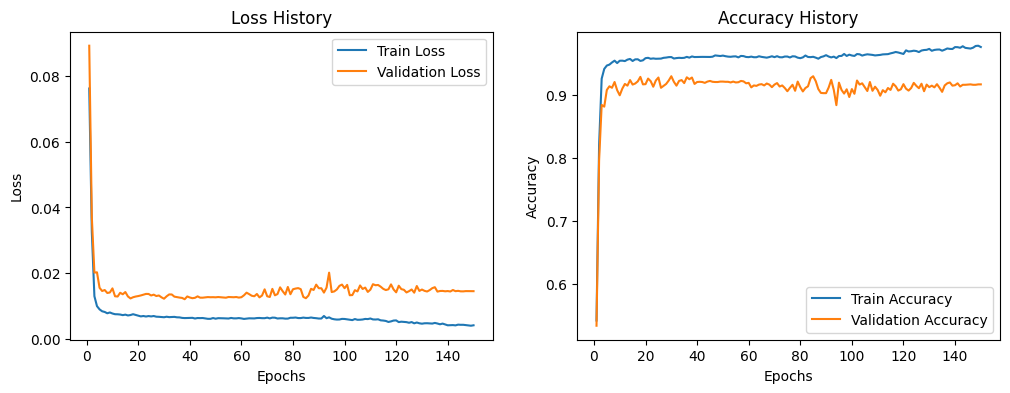

In [26]:
plot_history(history)

### TCN Model

In [23]:
class TCNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation_rate):
        super(TCNBlock, self).__init__()

        self.conv1 = nn.Conv1d(
            in_channels,
            out_channels,
            kernel_size,
            padding='same',
            dilation=dilation_rate
        )
        self.batch_norm = nn.BatchNorm1d(out_channels)

        # Residual connection
        if in_channels != out_channels:
            self.shortcut = nn.Conv1d(in_channels, out_channels, kernel_size=1)
        else:
            self.shortcut = None

    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = self.batch_norm(out)

        shortcut = self.shortcut(x) if self.shortcut is not None else x
        return F.relu(out + shortcut)

class TCNModel(nn.Module):
    def __init__(self, n_length, n_features, n_outputs):
        super(TCNModel, self).__init__()

        self.tcn_blocks = nn.Sequential(
            TCNBlock(n_features, 64, kernel_size=3, dilation_rate=1),
            TCNBlock(64, 64, kernel_size=3, dilation_rate=2),
            TCNBlock(64, 64, kernel_size=3, dilation_rate=4),
            TCNBlock(64, 64, kernel_size=3, dilation_rate=8)
        )

        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)
        self.fc1 = nn.Linear(64, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, n_outputs)

        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # Convert to (batch_size, n_features, n_length)
        x = self.tcn_blocks(x)

        x = self.global_avg_pool(x).squeeze(-1)  # Global average pooling

        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)

        return F.softmax(x, dim=1)

# Define model parameters
n_length = 128  
n_features = 9
n_outputs = 6

In [31]:
# Instantiate model
model = TCNModel(n_length, n_features, n_outputs).to(device)
summary(model)

Layer (type:depth-idx)                   Param #
TCNModel                                 --
├─Sequential: 1-1                        --
│    └─TCNBlock: 2-1                     --
│    │    └─Conv1d: 3-1                  1,792
│    │    └─BatchNorm1d: 3-2             128
│    │    └─Conv1d: 3-3                  640
│    └─TCNBlock: 2-2                     --
│    │    └─Conv1d: 3-4                  12,352
│    │    └─BatchNorm1d: 3-5             128
│    └─TCNBlock: 2-3                     --
│    │    └─Conv1d: 3-6                  12,352
│    │    └─BatchNorm1d: 3-7             128
│    └─TCNBlock: 2-4                     --
│    │    └─Conv1d: 3-8                  12,352
│    │    └─BatchNorm1d: 3-9             128
├─AdaptiveAvgPool1d: 1-2                 --
├─Linear: 1-3                            8,320
├─Linear: 1-4                            8,256
├─Linear: 1-5                            390
├─Dropout: 1-6                           --
Total params: 56,966
Trainable params: 56,96

In [32]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)
# scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda x: warmup_lr(x, warmup_epochs=WARMUP_EPOCHS, gamma=GAMMA, step_size=STEP_SIZE))
# scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = 50, eta_min = 1e-6)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

history = train_model(model, train_loader, test_loader, criterion=kl_divergence_loss, epochs=150, device=device, early_stopping=True)

Epoch 1/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 177.42batch/s, loss=0.0697]


Epoch 1/150 - Train Loss: 0.0670, Train Acc: 0.5092 - Val Loss: 0.0751, Val Acc: 0.6878


Epoch 2/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 185.74batch/s, loss=0.000419]


Epoch 2/150 - Train Loss: 0.0280, Train Acc: 0.8923 - Val Loss: 0.0226, Val Acc: 0.9148


Epoch 3/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 177.84batch/s, loss=6.66e-5]


Epoch 3/150 - Train Loss: 0.0105, Train Acc: 0.9460 - Val Loss: 0.0127, Val Acc: 0.9291


Epoch 4/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 188.27batch/s, loss=9.21e-6]


Epoch 4/150 - Train Loss: 0.0075, Train Acc: 0.9554 - Val Loss: 0.0160, Val Acc: 0.9043


Epoch 5/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 180.14batch/s, loss=9.63e-5]


Epoch 5/150 - Train Loss: 0.0070, Train Acc: 0.9576 - Val Loss: 0.0134, Val Acc: 0.9274


Epoch 6/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 191.18batch/s, loss=8.53e-5]


Epoch 6/150 - Train Loss: 0.0070, Train Acc: 0.9567 - Val Loss: 0.0124, Val Acc: 0.9308


Epoch 7/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 190.65batch/s, loss=2.66e-6]


Epoch 7/150 - Train Loss: 0.0068, Train Acc: 0.9611 - Val Loss: 0.0135, Val Acc: 0.9274


Epoch 8/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 192.35batch/s, loss=0.00057]


Epoch 8/150 - Train Loss: 0.0066, Train Acc: 0.9588 - Val Loss: 0.0138, Val Acc: 0.9179


Epoch 9/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 181.01batch/s, loss=5e-6]


Epoch 9/150 - Train Loss: 0.0054, Train Acc: 0.9648 - Val Loss: 0.0126, Val Acc: 0.9315


Epoch 10/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 191.77batch/s, loss=1.87e-6]


Epoch 10/150 - Train Loss: 0.0054, Train Acc: 0.9661 - Val Loss: 0.0121, Val Acc: 0.9328


Epoch 11/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 184.78batch/s, loss=1.4e-6]


Epoch 11/150 - Train Loss: 0.0052, Train Acc: 0.9682 - Val Loss: 0.0118, Val Acc: 0.9352


Epoch 12/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 189.23batch/s, loss=1.83e-6]


Epoch 12/150 - Train Loss: 0.0048, Train Acc: 0.9698 - Val Loss: 0.0120, Val Acc: 0.9355


Epoch 13/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 189.31batch/s, loss=1.32e-6]


Epoch 13/150 - Train Loss: 0.0049, Train Acc: 0.9683 - Val Loss: 0.0121, Val Acc: 0.9301


Epoch 14/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 190.80batch/s, loss=1.48e-6]


Epoch 14/150 - Train Loss: 0.0046, Train Acc: 0.9731 - Val Loss: 0.0125, Val Acc: 0.9247


Epoch 15/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 193.49batch/s, loss=1.77e-6]


Epoch 15/150 - Train Loss: 0.0046, Train Acc: 0.9720 - Val Loss: 0.0130, Val Acc: 0.9247


Epoch 16/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 180.38batch/s, loss=1.32e-6]


Epoch 16/150 - Train Loss: 0.0043, Train Acc: 0.9728 - Val Loss: 0.0130, Val Acc: 0.9247


Epoch 17/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 184.97batch/s, loss=9.2e-7]


Epoch 17/150 - Train Loss: 0.0046, Train Acc: 0.9699 - Val Loss: 0.0130, Val Acc: 0.9260


Epoch 18/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 190.52batch/s, loss=8.11e-7]


Epoch 18/150 - Train Loss: 0.0042, Train Acc: 0.9729 - Val Loss: 0.0129, Val Acc: 0.9260


Epoch 19/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 176.54batch/s, loss=7.47e-7]


Epoch 19/150 - Train Loss: 0.0041, Train Acc: 0.9737 - Val Loss: 0.0134, Val Acc: 0.9237


Epoch 20/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 187.59batch/s, loss=1.45e-6]


Epoch 20/150 - Train Loss: 0.0039, Train Acc: 0.9751 - Val Loss: 0.0135, Val Acc: 0.9253


Epoch 21/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 193.65batch/s, loss=6.8e-7]


Epoch 21/150 - Train Loss: 0.0036, Train Acc: 0.9780 - Val Loss: 0.0136, Val Acc: 0.9253


Epoch 22/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 189.07batch/s, loss=1.2e-6]


Epoch 22/150 - Train Loss: 0.0040, Train Acc: 0.9736 - Val Loss: 0.0135, Val Acc: 0.9267


Epoch 23/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 187.78batch/s, loss=8.27e-7]


Epoch 23/150 - Train Loss: 0.0038, Train Acc: 0.9742 - Val Loss: 0.0136, Val Acc: 0.9247


Epoch 24/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 188.83batch/s, loss=7.19e-7]


Epoch 24/150 - Train Loss: 0.0039, Train Acc: 0.9757 - Val Loss: 0.0135, Val Acc: 0.9267


Epoch 25/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 181.15batch/s, loss=9.29e-7]


Epoch 25/150 - Train Loss: 0.0037, Train Acc: 0.9767 - Val Loss: 0.0135, Val Acc: 0.9250


Epoch 26/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 179.66batch/s, loss=7.69e-7]


Epoch 26/150 - Train Loss: 0.0040, Train Acc: 0.9748 - Val Loss: 0.0134, Val Acc: 0.9250


Epoch 27/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 194.45batch/s, loss=5.87e-7]


Epoch 27/150 - Train Loss: 0.0038, Train Acc: 0.9748 - Val Loss: 0.0134, Val Acc: 0.9270


Epoch 28/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 195.84batch/s, loss=5.93e-7]


Epoch 28/150 - Train Loss: 0.0037, Train Acc: 0.9762 - Val Loss: 0.0136, Val Acc: 0.9243


Epoch 29/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 179.02batch/s, loss=4.28e-7]


Epoch 29/150 - Train Loss: 0.0038, Train Acc: 0.9758 - Val Loss: 0.0137, Val Acc: 0.9247


Epoch 30/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 190.71batch/s, loss=4.67e-7]


Epoch 30/150 - Train Loss: 0.0040, Train Acc: 0.9723 - Val Loss: 0.0136, Val Acc: 0.9257


Epoch 31/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 182.68batch/s, loss=6.02e-7]


Epoch 31/150 - Train Loss: 0.0038, Train Acc: 0.9748 - Val Loss: 0.0135, Val Acc: 0.9257


Epoch 32/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 175.88batch/s, loss=5.68e-7]


Epoch 32/150 - Train Loss: 0.0037, Train Acc: 0.9763 - Val Loss: 0.0136, Val Acc: 0.9250


Epoch 33/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 188.88batch/s, loss=6.58e-7]


Epoch 33/150 - Train Loss: 0.0038, Train Acc: 0.9758 - Val Loss: 0.0134, Val Acc: 0.9277


Epoch 34/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 190.25batch/s, loss=4.01e-7]


Epoch 34/150 - Train Loss: 0.0037, Train Acc: 0.9761 - Val Loss: 0.0136, Val Acc: 0.9257


Epoch 35/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 178.94batch/s, loss=7.08e-7]


Epoch 35/150 - Train Loss: 0.0036, Train Acc: 0.9771 - Val Loss: 0.0135, Val Acc: 0.9253


Epoch 36/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 182.86batch/s, loss=5.35e-7]


Epoch 36/150 - Train Loss: 0.0037, Train Acc: 0.9776 - Val Loss: 0.0135, Val Acc: 0.9250


Epoch 37/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 189.56batch/s, loss=5.5e-7]


Epoch 37/150 - Train Loss: 0.0038, Train Acc: 0.9750 - Val Loss: 0.0136, Val Acc: 0.9250


Epoch 38/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 181.59batch/s, loss=5.89e-7]


Epoch 38/150 - Train Loss: 0.0039, Train Acc: 0.9739 - Val Loss: 0.0135, Val Acc: 0.9264


Epoch 39/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 186.00batch/s, loss=7.03e-7]


Epoch 39/150 - Train Loss: 0.0039, Train Acc: 0.9752 - Val Loss: 0.0136, Val Acc: 0.9260


Epoch 40/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 190.02batch/s, loss=6.54e-7]


Epoch 40/150 - Train Loss: 0.0040, Train Acc: 0.9746 - Val Loss: 0.0135, Val Acc: 0.9250


Epoch 41/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 185.42batch/s, loss=5.34e-7]


Epoch 41/150 - Train Loss: 0.0038, Train Acc: 0.9747 - Val Loss: 0.0134, Val Acc: 0.9260


Epoch 42/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 189.21batch/s, loss=6.95e-7]


Epoch 42/150 - Train Loss: 0.0040, Train Acc: 0.9732 - Val Loss: 0.0135, Val Acc: 0.9267


Epoch 43/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 184.82batch/s, loss=5.12e-7]


Epoch 43/150 - Train Loss: 0.0038, Train Acc: 0.9751 - Val Loss: 0.0136, Val Acc: 0.9253


Epoch 44/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 190.84batch/s, loss=7.07e-7]


Epoch 44/150 - Train Loss: 0.0041, Train Acc: 0.9739 - Val Loss: 0.0135, Val Acc: 0.9257


Epoch 45/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 174.96batch/s, loss=6.42e-7]


Epoch 45/150 - Train Loss: 0.0040, Train Acc: 0.9771 - Val Loss: 0.0135, Val Acc: 0.9237


Epoch 46/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 179.41batch/s, loss=3.38e-7]


Epoch 46/150 - Train Loss: 0.0040, Train Acc: 0.9754 - Val Loss: 0.0136, Val Acc: 0.9253


Epoch 47/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 178.45batch/s, loss=5.55e-7]


Epoch 47/150 - Train Loss: 0.0038, Train Acc: 0.9744 - Val Loss: 0.0135, Val Acc: 0.9250


Epoch 48/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 188.83batch/s, loss=7.05e-7]


Epoch 48/150 - Train Loss: 0.0037, Train Acc: 0.9755 - Val Loss: 0.0133, Val Acc: 0.9270


Epoch 49/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 190.59batch/s, loss=7.12e-7]


Epoch 49/150 - Train Loss: 0.0038, Train Acc: 0.9750 - Val Loss: 0.0135, Val Acc: 0.9257


Epoch 50/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 180.73batch/s, loss=9.61e-7]


Epoch 50/150 - Train Loss: 0.0041, Train Acc: 0.9723 - Val Loss: 0.0134, Val Acc: 0.9277


Epoch 51/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 195.76batch/s, loss=7.89e-7]


Epoch 51/150 - Train Loss: 0.0040, Train Acc: 0.9731 - Val Loss: 0.0135, Val Acc: 0.9264


Epoch 52/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 191.82batch/s, loss=7.41e-7]


Epoch 52/150 - Train Loss: 0.0040, Train Acc: 0.9731 - Val Loss: 0.0135, Val Acc: 0.9260


Epoch 53/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 192.48batch/s, loss=6.27e-7]


Epoch 53/150 - Train Loss: 0.0039, Train Acc: 0.9733 - Val Loss: 0.0134, Val Acc: 0.9264


Epoch 54/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 195.15batch/s, loss=4.42e-7]


Epoch 54/150 - Train Loss: 0.0038, Train Acc: 0.9755 - Val Loss: 0.0136, Val Acc: 0.9253


Epoch 55/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 177.52batch/s, loss=9.18e-7]


Epoch 55/150 - Train Loss: 0.0038, Train Acc: 0.9752 - Val Loss: 0.0134, Val Acc: 0.9284


Epoch 56/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 178.16batch/s, loss=4.83e-7]


Epoch 56/150 - Train Loss: 0.0038, Train Acc: 0.9747 - Val Loss: 0.0136, Val Acc: 0.9253


Epoch 57/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 193.82batch/s, loss=5.06e-7]


Epoch 57/150 - Train Loss: 0.0040, Train Acc: 0.9748 - Val Loss: 0.0135, Val Acc: 0.9253


Epoch 58/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 195.18batch/s, loss=3.66e-7]


Epoch 58/150 - Train Loss: 0.0039, Train Acc: 0.9751 - Val Loss: 0.0137, Val Acc: 0.9264


Epoch 59/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 196.25batch/s, loss=4.83e-7]


Epoch 59/150 - Train Loss: 0.0040, Train Acc: 0.9754 - Val Loss: 0.0135, Val Acc: 0.9267


Epoch 60/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 190.41batch/s, loss=5.52e-7]


Epoch 60/150 - Train Loss: 0.0037, Train Acc: 0.9757 - Val Loss: 0.0136, Val Acc: 0.9250


Epoch 61/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 188.92batch/s, loss=5.63e-7]


Epoch 61/150 - Train Loss: 0.0038, Train Acc: 0.9742 - Val Loss: 0.0136, Val Acc: 0.9257


Epoch 62/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 176.03batch/s, loss=4.12e-7]


Epoch 62/150 - Train Loss: 0.0040, Train Acc: 0.9733 - Val Loss: 0.0136, Val Acc: 0.9240


Epoch 63/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 175.33batch/s, loss=5.63e-7]


Epoch 63/150 - Train Loss: 0.0037, Train Acc: 0.9763 - Val Loss: 0.0135, Val Acc: 0.9264


Epoch 64/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 185.51batch/s, loss=4.27e-7]


Epoch 64/150 - Train Loss: 0.0037, Train Acc: 0.9769 - Val Loss: 0.0136, Val Acc: 0.9253


Epoch 65/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 195.64batch/s, loss=6.53e-7]


Epoch 65/150 - Train Loss: 0.0039, Train Acc: 0.9742 - Val Loss: 0.0135, Val Acc: 0.9250


Epoch 66/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 194.57batch/s, loss=5.81e-7]


Epoch 66/150 - Train Loss: 0.0039, Train Acc: 0.9755 - Val Loss: 0.0136, Val Acc: 0.9264


Epoch 67/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 180.32batch/s, loss=5.46e-7]


Epoch 67/150 - Train Loss: 0.0037, Train Acc: 0.9751 - Val Loss: 0.0136, Val Acc: 0.9257


Epoch 68/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 193.82batch/s, loss=7.91e-7]


Epoch 68/150 - Train Loss: 0.0040, Train Acc: 0.9742 - Val Loss: 0.0135, Val Acc: 0.9264


Epoch 69/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 179.85batch/s, loss=4.58e-7]


Epoch 69/150 - Train Loss: 0.0039, Train Acc: 0.9752 - Val Loss: 0.0135, Val Acc: 0.9250


Epoch 70/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 164.98batch/s, loss=5.82e-7]


Epoch 70/150 - Train Loss: 0.0039, Train Acc: 0.9747 - Val Loss: 0.0136, Val Acc: 0.9267


Epoch 71/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 158.24batch/s, loss=6.09e-7]


Epoch 71/150 - Train Loss: 0.0038, Train Acc: 0.9740 - Val Loss: 0.0135, Val Acc: 0.9277


Epoch 72/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 187.06batch/s, loss=4.6e-7]


Epoch 72/150 - Train Loss: 0.0039, Train Acc: 0.9748 - Val Loss: 0.0135, Val Acc: 0.9264


Epoch 73/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 170.92batch/s, loss=7.41e-7]


Epoch 73/150 - Train Loss: 0.0037, Train Acc: 0.9766 - Val Loss: 0.0134, Val Acc: 0.9281


Epoch 74/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 193.05batch/s, loss=4.98e-7]


Epoch 74/150 - Train Loss: 0.0038, Train Acc: 0.9747 - Val Loss: 0.0136, Val Acc: 0.9247


Epoch 75/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 190.61batch/s, loss=5.53e-7]


Epoch 75/150 - Train Loss: 0.0036, Train Acc: 0.9769 - Val Loss: 0.0135, Val Acc: 0.9260


Epoch 76/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 177.89batch/s, loss=4.01e-7]


Epoch 76/150 - Train Loss: 0.0038, Train Acc: 0.9743 - Val Loss: 0.0136, Val Acc: 0.9257


Epoch 77/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 190.02batch/s, loss=8.42e-7]


Epoch 77/150 - Train Loss: 0.0040, Train Acc: 0.9735 - Val Loss: 0.0135, Val Acc: 0.9267


Epoch 78/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 178.98batch/s, loss=5.87e-7]


Epoch 78/150 - Train Loss: 0.0038, Train Acc: 0.9751 - Val Loss: 0.0135, Val Acc: 0.9247


Epoch 79/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 185.81batch/s, loss=5.11e-7]


Epoch 79/150 - Train Loss: 0.0037, Train Acc: 0.9761 - Val Loss: 0.0136, Val Acc: 0.9250


Epoch 80/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 189.51batch/s, loss=4.36e-7]


Epoch 80/150 - Train Loss: 0.0038, Train Acc: 0.9763 - Val Loss: 0.0135, Val Acc: 0.9240


Epoch 81/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 196.28batch/s, loss=8.91e-7]


Epoch 81/150 - Train Loss: 0.0039, Train Acc: 0.9752 - Val Loss: 0.0136, Val Acc: 0.9253


Epoch 82/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 180.84batch/s, loss=6.07e-7]


Epoch 82/150 - Train Loss: 0.0037, Train Acc: 0.9759 - Val Loss: 0.0135, Val Acc: 0.9250


Epoch 83/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 190.74batch/s, loss=7.78e-7]


Epoch 83/150 - Train Loss: 0.0037, Train Acc: 0.9754 - Val Loss: 0.0134, Val Acc: 0.9267


Epoch 84/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 188.46batch/s, loss=6.82e-7]


Epoch 84/150 - Train Loss: 0.0039, Train Acc: 0.9744 - Val Loss: 0.0135, Val Acc: 0.9267


Epoch 85/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 182.02batch/s, loss=5.49e-7]


Epoch 85/150 - Train Loss: 0.0041, Train Acc: 0.9732 - Val Loss: 0.0135, Val Acc: 0.9253


Epoch 86/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 191.15batch/s, loss=5.8e-7]


Epoch 86/150 - Train Loss: 0.0039, Train Acc: 0.9748 - Val Loss: 0.0136, Val Acc: 0.9253


Epoch 87/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 188.59batch/s, loss=6.79e-7]


Epoch 87/150 - Train Loss: 0.0039, Train Acc: 0.9744 - Val Loss: 0.0135, Val Acc: 0.9260


Epoch 88/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 175.52batch/s, loss=5.5e-7]


Epoch 88/150 - Train Loss: 0.0035, Train Acc: 0.9786 - Val Loss: 0.0135, Val Acc: 0.9267


Epoch 89/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 189.33batch/s, loss=5.68e-7]


Epoch 89/150 - Train Loss: 0.0036, Train Acc: 0.9765 - Val Loss: 0.0134, Val Acc: 0.9267


Epoch 90/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 187.78batch/s, loss=5.26e-7]


Epoch 90/150 - Train Loss: 0.0037, Train Acc: 0.9763 - Val Loss: 0.0134, Val Acc: 0.9257


Epoch 91/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 179.47batch/s, loss=3.54e-7]


Epoch 91/150 - Train Loss: 0.0037, Train Acc: 0.9752 - Val Loss: 0.0136, Val Acc: 0.9233


Epoch 92/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 190.02batch/s, loss=6.69e-7]


Epoch 92/150 - Train Loss: 0.0041, Train Acc: 0.9727 - Val Loss: 0.0135, Val Acc: 0.9260


Epoch 93/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 188.71batch/s, loss=4.9e-7]


Epoch 93/150 - Train Loss: 0.0039, Train Acc: 0.9751 - Val Loss: 0.0136, Val Acc: 0.9253


Epoch 94/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 178.67batch/s, loss=8.93e-7]


Epoch 94/150 - Train Loss: 0.0040, Train Acc: 0.9737 - Val Loss: 0.0135, Val Acc: 0.9267


Epoch 95/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 192.70batch/s, loss=6.13e-7]


Epoch 95/150 - Train Loss: 0.0041, Train Acc: 0.9728 - Val Loss: 0.0135, Val Acc: 0.9257


Epoch 96/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 188.28batch/s, loss=5.71e-7]


Epoch 96/150 - Train Loss: 0.0037, Train Acc: 0.9757 - Val Loss: 0.0136, Val Acc: 0.9257


Epoch 97/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 178.82batch/s, loss=5.01e-7]


Epoch 97/150 - Train Loss: 0.0038, Train Acc: 0.9751 - Val Loss: 0.0135, Val Acc: 0.9253


Epoch 98/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 181.41batch/s, loss=6.58e-7]


Epoch 98/150 - Train Loss: 0.0037, Train Acc: 0.9770 - Val Loss: 0.0135, Val Acc: 0.9264


Epoch 99/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 192.56batch/s, loss=5.22e-7]


Epoch 99/150 - Train Loss: 0.0037, Train Acc: 0.9758 - Val Loss: 0.0134, Val Acc: 0.9270


Epoch 100/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 178.54batch/s, loss=4.75e-7]


Epoch 100/150 - Train Loss: 0.0036, Train Acc: 0.9765 - Val Loss: 0.0136, Val Acc: 0.9257


Epoch 101/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 188.98batch/s, loss=8.01e-7]


Epoch 101/150 - Train Loss: 0.0037, Train Acc: 0.9763 - Val Loss: 0.0136, Val Acc: 0.9257


Epoch 102/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 189.54batch/s, loss=4.38e-7]


Epoch 102/150 - Train Loss: 0.0037, Train Acc: 0.9761 - Val Loss: 0.0136, Val Acc: 0.9233
Early stopping triggered!


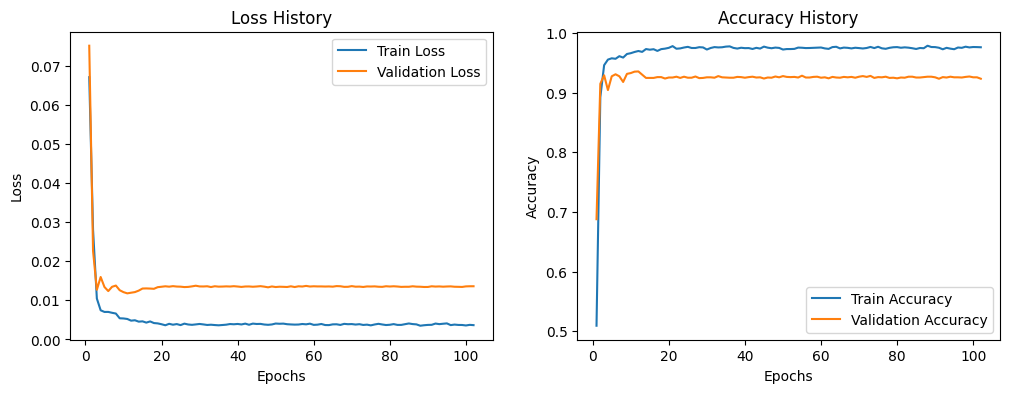

In [33]:
plot_history(history)

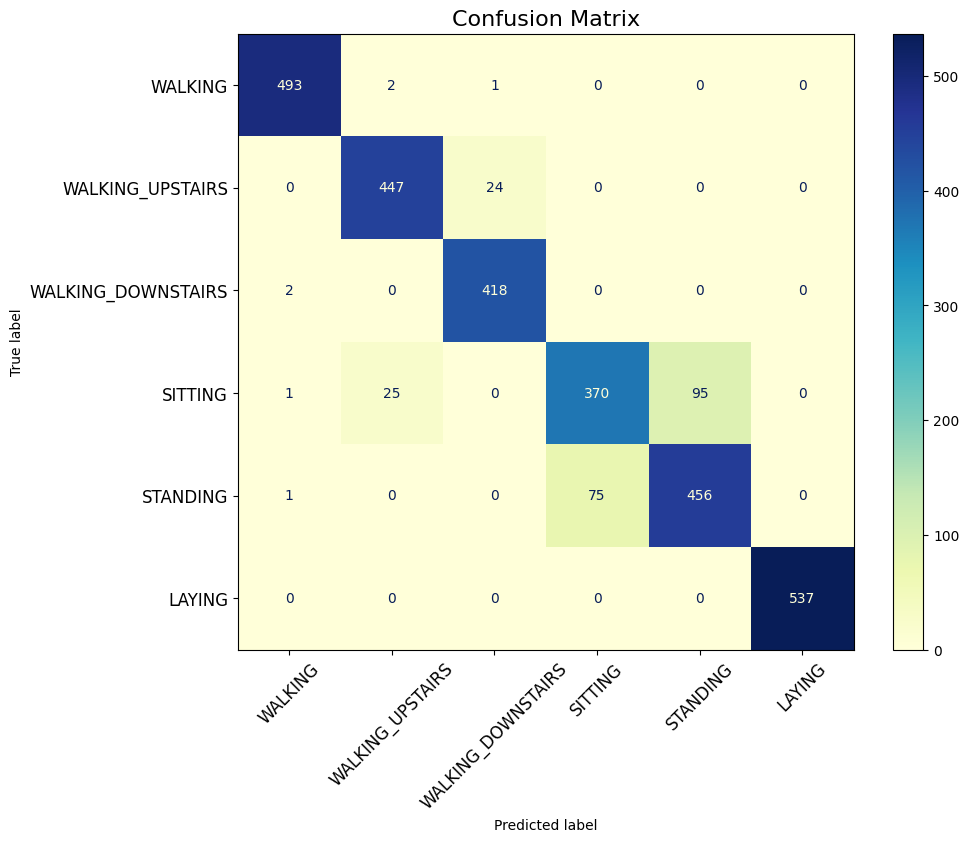

In [45]:
plot_confusion_matrix(model, test_loader, class_names=["WALKING", "WALKING_UPSTAIRS", "WALKING_DOWNSTAIRS", "SITTING", "STANDING", "LAYING"])

### TCN + CBAM Model

In [171]:
class ChannelAttention(nn.Module):
    def __init__(self, in_channels, reduction_ratio=8):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        self.max_pool = nn.AdaptiveMaxPool1d(1)
        self.fc1 = nn.Conv1d(in_channels, in_channels // reduction_ratio, kernel_size=1)
        self.fc2 = nn.Conv1d(in_channels // reduction_ratio, in_channels, kernel_size=1)

    def forward(self, x):
        avg_pool = self.avg_pool(x)
        max_pool = self.max_pool(x)

        avg_out = F.relu(self.fc1(avg_pool))
        avg_out = self.fc2(avg_out)

        max_out = F.relu(self.fc1(max_pool))
        max_out = self.fc2(max_out)

        out = avg_out + max_out
        return torch.sigmoid(out) * x  # Channel attention applied

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        self.conv = nn.Conv1d(2, 1, kernel_size=kernel_size, padding=kernel_size//2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_pool = torch.mean(x, dim=1, keepdim=True)
        max_pool, _ = torch.max(x, dim=1, keepdim=True)
        x_cat = torch.cat([avg_pool, max_pool], dim=1)  # Concatenate along channel dimension
        out = self.conv(x_cat)
        return self.sigmoid(out) * x  # Spatial attention applied

class CBAMBlock(nn.Module):
    def __init__(self, in_channels):
        super(CBAMBlock, self).__init__()
        self.channel_attention = ChannelAttention(in_channels)
        self.spatial_attention = SpatialAttention()

    def forward(self, x):
        x = self.channel_attention(x)
        x = self.spatial_attention(x)
        return x

class TCNWithCBAM(nn.Module):
    def __init__(self, n_length, n_features, n_outputs):
        super(TCNWithCBAM, self).__init__()

        self.tcn_blocks = nn.Sequential(
            TCNBlock(n_features, 64, kernel_size=3, dilation_rate=1),
            TCNBlock(64, 128, kernel_size=3, dilation_rate=2),
            TCNBlock(128, 256, kernel_size=3, dilation_rate=4),
            TCNBlock(256, 512, kernel_size=3, dilation_rate=8)
        ) # (batch_size, out_channels, n_length)

        self.cbam_block = CBAMBlock(512)

        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)
        self.fc1 = nn.Linear(512, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, n_outputs)

        self.batch_norm = nn.BatchNorm1d(512)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # Convert to (batch_size, n_features, n_length)
        x = self.tcn_blocks(x)
        x = self.batch_norm(x)

        # Apply CBAM
        x = self.cbam_block(x)

        x = self.global_avg_pool(x).squeeze(-1)  # Global average pooling

        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)

        return F.softmax(x, dim=1)

# Define model parameters
n_length = 128  
n_features = 9
n_outputs = 6

In [172]:
model = TCNWithCBAM(n_length, n_features, n_outputs).to(device)
summary(model)

Layer (type:depth-idx)                   Param #
TCNWithCBAM                              --
├─Sequential: 1-1                        --
│    └─TCNBlock: 2-1                     --
│    │    └─Conv1d: 3-1                  1,792
│    │    └─BatchNorm1d: 3-2             128
│    │    └─Conv1d: 3-3                  640
│    └─TCNBlock: 2-2                     --
│    │    └─Conv1d: 3-4                  24,704
│    │    └─BatchNorm1d: 3-5             256
│    │    └─Conv1d: 3-6                  8,320
│    └─TCNBlock: 2-3                     --
│    │    └─Conv1d: 3-7                  98,560
│    │    └─BatchNorm1d: 3-8             512
│    │    └─Conv1d: 3-9                  33,024
│    └─TCNBlock: 2-4                     --
│    │    └─Conv1d: 3-10                 393,728
│    │    └─BatchNorm1d: 3-11            1,024
│    │    └─Conv1d: 3-12                 131,584
├─CBAMBlock: 1-2                         --
│    └─ChannelAttention: 2-5             --
│    │    └─AdaptiveAvgPool1d: 3-13 

In [ ]:
history = train_model(model, train_loader, test_loader, epochs=150, device=device, early_stopping=True)

Epoch 1/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 58.78batch/s, loss=0.125]


Epoch 1/150 - Train Loss: 0.0582, Train Acc: 0.6298 - Val Loss: 0.1017, Val Acc: 0.2019


Epoch 2/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 59.44batch/s, loss=0.000334]


Epoch 2/150 - Train Loss: 0.0156, Train Acc: 0.9180 - Val Loss: 0.0162, Val Acc: 0.9158


Epoch 3/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 59.90batch/s, loss=4e-7]   


Epoch 3/150 - Train Loss: 0.0086, Train Acc: 0.9536 - Val Loss: 0.0174, Val Acc: 0.9006


Epoch 4/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 60.06batch/s, loss=5.17e-6]


Epoch 4/150 - Train Loss: 0.0078, Train Acc: 0.9546 - Val Loss: 0.0158, Val Acc: 0.9135


Epoch 5/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 58.48batch/s, loss=4.53e-6]


Epoch 5/150 - Train Loss: 0.0079, Train Acc: 0.9538 - Val Loss: 0.0163, Val Acc: 0.9152


Epoch 6/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 56.75batch/s, loss=3.72e-7]


Epoch 6/150 - Train Loss: 0.0067, Train Acc: 0.9604 - Val Loss: 0.0192, Val Acc: 0.8972


Epoch 7/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 58.82batch/s, loss=8.74e-8]


Epoch 7/150 - Train Loss: 0.0059, Train Acc: 0.9629 - Val Loss: 0.0149, Val Acc: 0.9209


Epoch 8/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 58.72batch/s, loss=-5.53e-8]


Epoch 8/150 - Train Loss: 0.0059, Train Acc: 0.9649 - Val Loss: 0.0129, Val Acc: 0.9270


Epoch 9/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 58.70batch/s, loss=1.81e-7]


Epoch 9/150 - Train Loss: 0.0052, Train Acc: 0.9687 - Val Loss: 0.0131, Val Acc: 0.9270


Epoch 10/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 59.13batch/s, loss=-6.46e-8]


Epoch 10/150 - Train Loss: 0.0044, Train Acc: 0.9723 - Val Loss: 0.0137, Val Acc: 0.9298


Epoch 11/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 59.15batch/s, loss=-7.1e-8]


Epoch 11/150 - Train Loss: 0.0047, Train Acc: 0.9709 - Val Loss: 0.0157, Val Acc: 0.9165


Epoch 12/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 60.15batch/s, loss=-3.69e-8]


Epoch 12/150 - Train Loss: 0.0045, Train Acc: 0.9735 - Val Loss: 0.0134, Val Acc: 0.9274


Epoch 13/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 59.14batch/s, loss=-1.68e-8]


Epoch 13/150 - Train Loss: 0.0042, Train Acc: 0.9777 - Val Loss: 0.0128, Val Acc: 0.9311


Epoch 14/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 59.86batch/s, loss=1.13e-7]


Epoch 14/150 - Train Loss: 0.0045, Train Acc: 0.9739 - Val Loss: 0.0148, Val Acc: 0.9240


Epoch 15/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 59.86batch/s, loss=-2.09e-8]


Epoch 15/150 - Train Loss: 0.0048, Train Acc: 0.9710 - Val Loss: 0.0116, Val Acc: 0.9338


Epoch 16/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 57.93batch/s, loss=-2.27e-8]


Epoch 16/150 - Train Loss: 0.0039, Train Acc: 0.9755 - Val Loss: 0.0120, Val Acc: 0.9365


Epoch 17/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 59.09batch/s, loss=-1.5e-8]


Epoch 17/150 - Train Loss: 0.0037, Train Acc: 0.9773 - Val Loss: 0.0114, Val Acc: 0.9379


Epoch 18/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 59.43batch/s, loss=-5.76e-8]


Epoch 18/150 - Train Loss: 0.0037, Train Acc: 0.9769 - Val Loss: 0.0139, Val Acc: 0.9294


Epoch 19/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 59.18batch/s, loss=8.65e-7]


Epoch 19/150 - Train Loss: 0.0037, Train Acc: 0.9770 - Val Loss: 0.0109, Val Acc: 0.9389


Epoch 20/150 - Validation:  50%|█████     | 6/12 [00:00<00:00, 58.32batch/s, loss=0.000212]

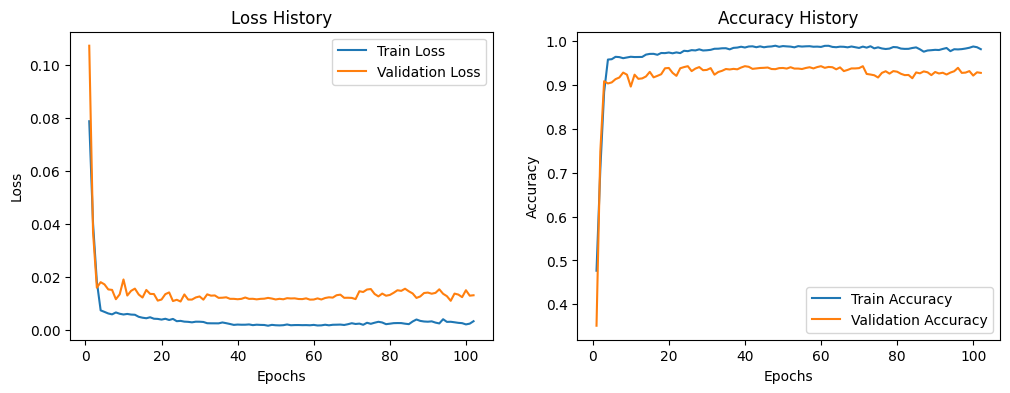

In [164]:
plot_history(history)

## Log

RNN + Attention + KL Div + Adam + CosineAnnealingLR ->  Train Acc: 0.9606; Val Acc: 0.9192 \
TCN + KL Div + Adam + StepLR -> Train Acc: 0.9698; Val Acc: 0.9355